 ## Мониторинг и управление качеством моделей

#### Задача: необходимо реализовать мониторинг модели с помощью Prometheus и Grafana

Для подобной задачи, удобнее было бы использовать push модель сбора данных (к примеру, с помощью graphite).  
Так как задача состоит в использовании Prometheus, тогда реализуем передачу метрик своими силами.  
Воспольземся модулем Flask.  
PS: Можно было бы использовать Prometheus Python Client, но задача решается очень просто и без него.

В качестве набора данных будем использовать датасет Airlines для предсказания задержек рейсов.  
Airlines Dataset to predict a delay https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb

from threading import Thread
from queue import Queue

from flask import Flask

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [2]:
app = Flask(__name__)

In [3]:
# Будем использовать очередь для буфера значений метрик
q = Queue()

In [4]:
# Импорт данных
data = pd.read_csv('data/Airlines.csv')

#### EDA

In [5]:
data.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


Датасет не содержит Nan значений.  
Включает категориальные и числовые признаки.  
Целевая переменная Delay - бинарный признак, задержка ваиарейсов

<AxesSubplot:xlabel='Delay', ylabel='count'>

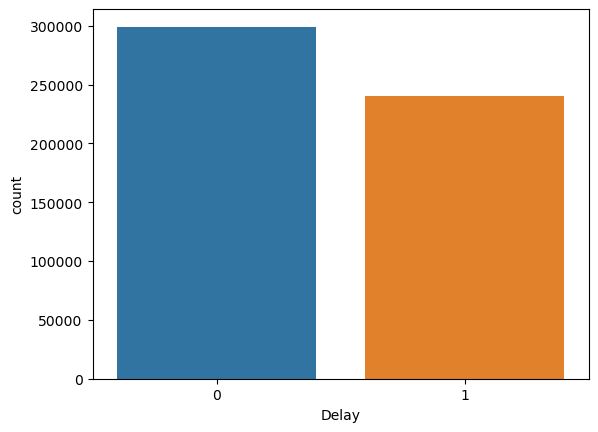

In [7]:
sns.countplot(x=data.Delay)

Довольно большое количество задержек

In [8]:
# Удаляем лишний признак из датасета
def remove_id(df):
    return df.drop(['id'], axis=1)

data = remove_id(data)

In [9]:
# Посмотрим на уникальные значения
for column in data.columns:
    print(column, len(data[column].unique()))

Airline 18
Flight 6585
AirportFrom 293
AirportTo 293
DayOfWeek 7
Time 1131
Length 426
Delay 2


In [10]:
# Воспользуемся LabelEncoder чтобы преобразовать категориалные параметры
def l_encode(df):
    le = LabelEncoder()
    df['Airline'] = le.fit_transform(df['Airline'])
    
    le = LabelEncoder()
    le.fit(df.AirportFrom)
    
    for column in ['AirportFrom', 'AirportTo']:
        df[column] = le.transform(df[column])
    return df

data = l_encode(data)

In [11]:
# Поссмотрим на корреляцию
corr = data.corr()
corr

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
Airline,1.000000,0.095285,0.098237,0.098791,-0.007258,0.004381,-0.207061,0.066936
Flight,0.095285,1.000000,-0.021802,-0.022072,0.000416,-0.005750,-0.341481,-0.046175
AirportFrom,0.098237,-0.021802,1.000000,0.015139,0.003732,-0.031555,0.049698,0.018459
AirportTo,0.098791,-0.022072,0.015139,1.000000,0.003846,0.030599,0.086982,0.047990
DayOfWeek,-0.007258,0.000416,0.003732,0.003846,1.000000,0.001273,0.013397,-0.026199
Time,0.004381,-0.005750,-0.031555,0.030599,0.001273,1.000000,-0.020612,0.150454
Length,-0.207061,-0.341481,0.049698,0.086982,0.013397,-0.020612,1.000000,0.040489
Delay,0.066936,-0.046175,0.018459,0.047990,-0.026199,0.150454,0.040489,1.000000


<AxesSubplot:>

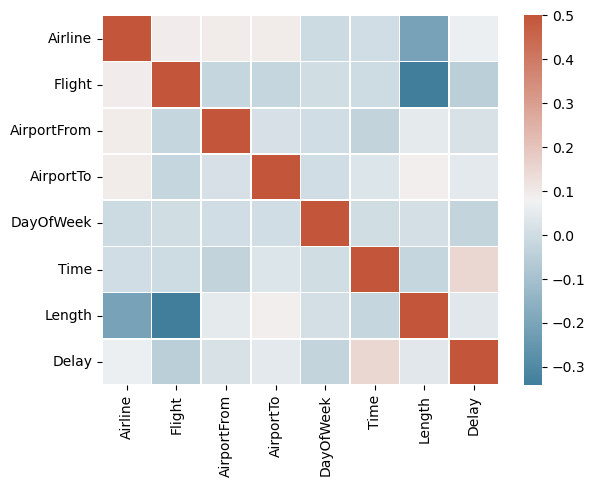

In [12]:
# Визуализируем матрицу
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, vmax=.5, cmap=cmap, linewidths=.5)

С целевой переменной больше всего коррелирует Time. Попробуем усилить фичи, добавив новые параметры на основе времени

In [13]:
# В минутах не очень удобно ориентироваться, конвертируем в часы
def convert_to_hours(df):
    for column in ['Time', 'Length']:
        df[column] = df[column] // 60
    return df

data = convert_to_hours(data)

In [14]:
# Новые признак (ночь/утро/обед/вечер)
def convert_time(x):
    if x < 6:
        return 0
    elif x < 12:
        return 1
    elif x < 18:
        return 2
    elif x < 24:
        return 3
    return None


# Новый признак
data['Time_ft'] = data.Time.apply(convert_time)

In [15]:
# Разделим дни недели на рабочие и выходные
data.DayOfWeek.value_counts()

4    91445
3    89746
5    85248
1    72769
2    71340
7    69879
6    58956
Name: DayOfWeek, dtype: int64

In [16]:
def weekend(x):
    """ Определеяет выходные дни """
    if x > 5:
        return 1
    else:
        return 0

In [17]:
data['Weekend'] = data.DayOfWeek.apply(weekend)

<AxesSubplot:>

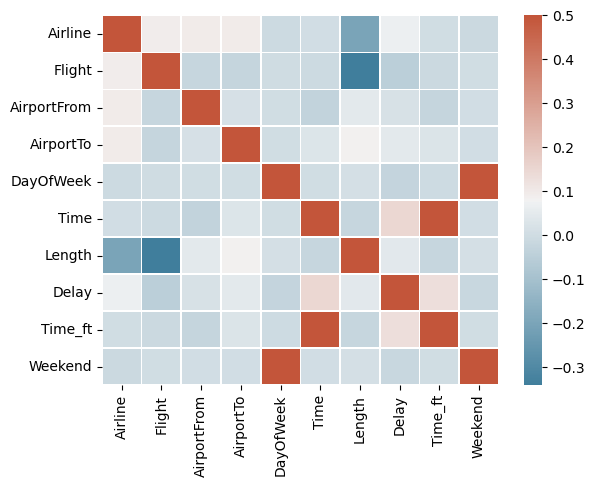

In [18]:
corr = data.corr()
sns.heatmap(corr, vmax=.5, cmap=cmap, linewidths=.5)

Теперь, соберем всё вместе

In [19]:
def data_preprocessing(dataset):
    """ Подготовка датасета """
    dataset = remove_id(dataset)
    dataset = l_encode(dataset)
    dataset = convert_to_hours(dataset)
    dataset['Time_ft'] = dataset.Time.apply(convert_time)
    dataset['Weekend'] = dataset.DayOfWeek.apply(weekend)
    # Разобъем Airline на отдельные признаки
    dataset = pd.get_dummies(dataset, columns=['Airline'], drop_first=True)
    return dataset

In [20]:
# Контрольная проверка
data = pd.read_csv('data/Airlines.csv')

data = data_preprocessing(data)
X = data.drop(['Delay'], axis=1)
y = data['Delay']

Для иммитации онлайн потока данных разобъем датасет на батчи и будем выдавать по 5000 наблюдений

In [21]:
def streaming_data(NX, ny, batch=5000):
    """ Разбивает входные данные на батчи """
    start = 0
    while start < len(NX):
        yield (NX.iloc[start:start+batch], ny.iloc[start:start+batch])
        start += batch

In [22]:
def IncrementaLightGbm(X, y):
    gbm = None

    params = {
        'task': 'train',
        'application': 'binary',  
        'boosting_type': 'gbdt', 
        'learning_rate': 0.05,  
        'tree_learner': 'serial',
        'metric': ['binary_logloss', 'auc'], 
        'max_bin': 255,
    }

    streaming_train_iterators = streaming_data(X, y)

    for X_batch, y_batch in streaming_train_iterators:
        X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.1, random_state=42)
        y_train = y_train.ravel()
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=1000,
                        valid_sets=lgb_eval,
                        init_model=gbm, 
                        early_stopping_rounds=10,
                        verbose_eval=False,
                        keep_training_booster=True)  
        
        y_predict = gbm.predict(X_test)
        pred_classes = np.where(y_predict > 0.5, 1, 0)
        
        # Расчитываем метрики и передаем в очередь
        q.put({'f1_score': round(f1_score(y_test, pred_classes), 5),
               'precision_score': round(precision_score(y_test, pred_classes), 5),
               'recall_score': round(recall_score(y_test, pred_classes), 5),
               'accuracy_score': round(accuracy_score(y_test, pred_classes), 5)
              }
        )

    return gbm

In [23]:
# gbm = IncrementaLightGbm(X, y)

In [24]:
@app.route('/metrics')
def get_metric():
    """ Функция возвращает набор метрик в формате prometheus """
    if q.qsize()>0:
        metrics = q.get()
        return '\n'.join([f'ml_scrape_collector{{collector="f1_score"}} {metrics["f1_score"]}',
        f'ml_scrape_collector{{collector="precision_score"}} {metrics["precision_score"]}',
        f'ml_scrape_collector{{collector="recall_score"}} {metrics["recall_score"]}',
        f'ml_scrape_collector{{collector="accuracy_score"}} {metrics["accuracy_score"]}',
        ])

In [ ]:
if __name__ == '__main__':
    # Будем выполнять дообучение отдельным потоком
    t = Thread(target=IncrementaLightGbm, args=(X, y,))
    t.daemon = True
    t.run()
    # Основной поток, web-server 
    app.run(host='0.0.0.0', port=8080)

[LightGBM] [Info] Number of positive: 1470, number of negative: 3030
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326667 -> initscore=-0.723300
[LightGBM] [Info] Start training from score -0.723300
[LightGBM] [Info] Number of positive: 2255, number of negative: 2245
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 23
[LightGBM] [Info] Number of positive: 2346, number of negative: 2154
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of te

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8080
 * Running on http://192.168.42.100:8080
Press CTRL+C to quit
127.0.0.1 - - [09/Jul/2023 13:51:02] "GET /metrics HTTP/1.1" 200 -
